In [10]:
import sys, os, time
import pyzx as zx
from benchmarking import Benchmark
import numpy as np
import argparse
import time
from distutils.util import strtobool
from typing import Optional

import gymnasium as gym
import gym_zx

import numpy as np
import torch
from torch_geometric.data import Batch, Data
from rl_agent import AgentGNN

global device




In [20]:
b = Benchmark()

In [21]:
b.load_circuits(
    dirname=os.path.join("results", "circuits", "Original"),
    group_name="fast",
)
b.load_circuits(
    dirname=os.path.join("results", "circuits", "nrscm"),
    group_name="fast",
    simp_strategy="NRSCM",
)
b.load_circuits(
    dirname=os.path.join("results", "circuits", "rl-zx-opt"),
    group_name="fast",
    simp_strategy="RL-ZX",
)
b.load_circuits(
    dirname=os.path.join("results", "circuits", "gflow-cflow-opt"),
    group_name="fast",
    simp_strategy="gflow+cflow",
)
"""b.load_circuits(
    dirname=os.path.join("results", "circuits", "random-zx"),
    group_name="fast",
    simp_strategy="random-zx",
)"""



'b.load_circuits(\n    dirname=os.path.join("results", "circuits", "random-zx"),\n    group_name="fast",\n    simp_strategy="random-zx",\n)'

In [22]:
f = b.df(groups=["fast"], routines=["all"], funcs=["all"], atts=["Qubits","Gates","Single Qubit", "2Q Count"], json_file="results/best_random_stats.json")

In [5]:

def basic_optimise(c):
    c1 = zx.basic_optimization(c.copy(), do_swaps=False).to_basic_gates()
    c2 = zx.basic_optimization(c.copy(), do_swaps=True).to_basic_gates()
    if c2.twoqubitcount() < c1.twoqubitcount(): return c2 # As this optimisation algorithm is targetted at reducting H-gates, we use the circuit with the smaller 2-qubit gate count here, either using SWAP rules or not.
    return c1

def flow_opt(c):
    c.to_basic_gates()
    g = c.to_graph()
    zx.teleport_reduce(g)
    zx.to_graph_like(g)
    zx.flow_2Q_simp(g)
    c2 = zx.extract_simple(g, up_to_perm=True).to_basic_gates()
    return basic_optimise(c2)


In [6]:
#b.add_simplification_func(func=rl_zx, name="RL-ZX", groups_to_run=None, verify=False)
b.add_simplification_func(func=flow_opt, name="cflow-opt", groups_to_run=["fast"], verify=False, rerun=False)


b.run(funcs_to_run=["cflow-opt"], groups_to_run=["fast"], verify=True, rerun=True)

b.show_attributes()

Processing cflow-opt on vbe_adder_3                                   : 100%|██████████| 33/33 [01:04<00:00,  1.97s/it]
Processing cflow-opt on adder_8                                       :  15%|█▌        | 5/33 [00:33<02:37,  5.63s/it]

Circuit resulting from cflow-opt on adder_8 not verified


Processing cflow-opt on csla_mux_3_original                           :  30%|███       | 10/33 [00:42<00:42,  1.87s/it]

Circuit resulting from cflow-opt on csla_mux_3_original not verified


Processing cflow-opt on ham15-low                                     :  55%|█████▍    | 18/33 [00:59<00:48,  3.22s/it]

Circuit resulting from cflow-opt on ham15-low not verified


Processing cflow-opt on hwb6                                          :  58%|█████▊    | 19/33 [01:04<00:54,  3.88s/it]

Circuit resulting from cflow-opt on hwb6 not verified


Processing cflow-opt on vbe_adder_3                                   :  97%|█████████▋| 32/33 [01:15<00:00,  1.87it/s]

Circuit resulting from cflow-opt on vbe_adder_3 not verified


Processing cflow-opt on vbe_adder_3                                   : 100%|██████████| 33/33 [01:15<00:00,  2.29s/it]

Circuit attributes:  ['Qubits', 'Gates', 'Single Qubit', '2Q Count', 'T Count', 't_opt', 'depth']
Loaded functions:  ['cflow-opt']
Loaded routines:  ['NRSCM', 'gflow+cflow', 'RL-ZX']
Loaded circuit groups:  ['fast']


,Original,NRSCM,RL-ZX,cflow-opt,gflow+cflow
fast,Y,Y,Y,Y,Y


In [7]:
df = b.df(groups=["fast"], routines=["all"], funcs=["NRSCM" ,"RL-ZX", "Random-RL-ZX" , "cflow-opt", "gflow+cflow"], atts=["Qubits","Gates","Single Qubit", "2Q Count"], json_file="results/best_random_stats.json")

The function NRSCM has not been added. Call <benchmark>.show_attributes() to see loaded functions.
The function RL-ZX has not been added. Call <benchmark>.show_attributes() to see loaded functions.
The function Random-RL-ZX has not been added. Call <benchmark>.show_attributes() to see loaded functions.
The function gflow+cflow has not been added. Call <benchmark>.show_attributes() to see loaded functions.


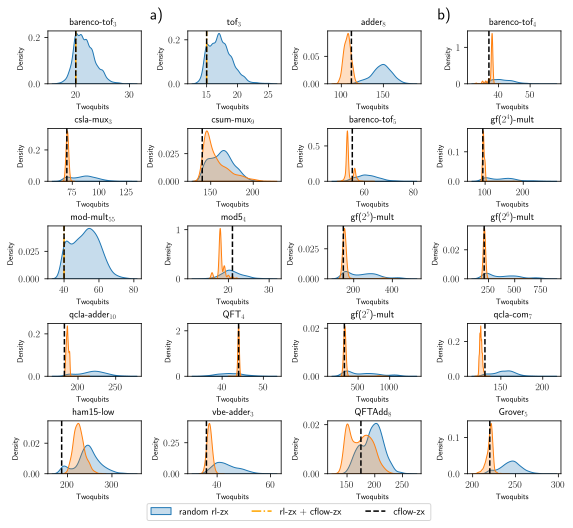

In [3]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Enable LaTeX formatting with standard configuration
plt.rcParams['text.usetex'] = True

script_dir = os.getcwd()
# Define the folders and full paths
base_path = os.path.join(script_dir, "results", "data")
folders = ["random_stats", "rl_stats"]
full_paths = {folder: os.path.join(base_path, folder) for folder in folders}

all_circuits = ["barenco_tof_3", "tof_3","Adder8", "barenco_tof_4", "csla_mux_3_original", "csum_mux_9_corrected","barenco_tof_5", "gf2^4_mult",
                "mod_mult_55", "mod5_4", "gf2^5_mult", "gf2^6_mult","qcla_adder_10", "qft_4","gf2^7_mult", "qcla_com_7","ham15-low", "vbe_adder_3","QFTAdd8", "grover_5"]
cflow = {
    "Adder8": 112, "barenco_tof_4": 37, "barenco_tof_5": 55, "gf2^4_mult": 94, "gf2^5_mult": 146, "gf2^6_mult": 209, "gf2^7_mult": 283, "gf2^8_mult": 383, "qcla_com_7": 131, "QFTAdd8": 175, "grover_5": 220,
    "vbe_adder_3": 36, "tof_3": 15, "qft_4": 44, "qcla_adder_10": 182, "mod_mult_55": 40, "csum_mux_9_corrected": 140, "mod5_4": 21, "ham15-low": 187, "csla_mux_3_original": 70, "barenco_tof_3": 20
}
circuits_name = {
    "Adder8": "adder$_8$", "barenco_tof_4": "barenco-tof$_4$", "barenco_tof_5": "barenco-tof$_5$", "gf2^4_mult": "gf($2^4$)-mult", "gf2^5_mult": "gf(${2^5}$)-mult",
    "gf2^6_mult": "gf(${2^6}$)-mult", "gf2^7_mult": "gf(${2^7}$)-mult", "gf2^8_mult": "gf(${2^8}$)-mult", "qcla_com_7": "qcla-com$_7$", "QFTAdd8": "QFTAdd$_8$", "grover_5": "Grover$_5$",
    "vbe_adder_3": "vbe-adder$_3$", "tof_3": "tof$_3$", "qft_4": "QFT$_4$", "qcla_adder_10": "qcla-adder$_{10}$", "mod_mult_55": "mod-mult$_{55}$", "mod5_4": "mod5$_4$", "ham15-low": "ham15-low",
    "csla_mux_3_original": "csla-mux$_3$", "barenco_tof_3": "barenco-tof$_3$", "csum_mux_9_corrected": "csum-mux$_9$"
}

# Function to read JSON files and extract data
def read_json_file(folder, circuit_name):
    if folder == "random_stats":
        specific_path = "_rand_policy_stats.json"
    else:
        specific_path = "_rl_stats.json"
    file_path = os.path.join(full_paths[folder], f"{circuit_name}{specific_path}")
    if os.path.isfile(file_path):
        with open(file_path, 'r') as file:
            data = json.load(file)
            return data["twoqubit"]
    return []

# Create a single figure with 10 rows and 4 columns
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(8, 8))
axes = axes.flatten()

# Initialize variables to store handles and labels for a shared legend
handles, labels = None, None

# Plot KDE or line for each circuit
for idx, circuit_name in enumerate(all_circuits):
    data_random = read_json_file("random_stats", circuit_name)
    data_rl = read_json_file("rl_stats", circuit_name)

    ax = axes[idx]  # Select subplot

    if data_random and len(set(data_random)) == 1:
        ax.axvline(data_random[0], label='random rl-zx', color='blue', linestyle='--')
    elif data_random:
        sns.kdeplot(
            data_random, label='random rl-zx',
            bw_adjust=1 if circuit_name in ['qft_4', 'csla_mux_3_original'] else 1,
            fill=True, ax=ax
        )

    if data_rl and len(set(data_rl)) == 1:
        ax.axvline(data_rl[0], label='rl-zx + cflow-zx', color='orange', linestyle='-.')
    elif data_rl:
        sns.kdeplot(
            data_rl, label='RL Policy',
            bw_adjust=8 if circuit_name in ['qft_4', 'csla_mux_3_original', 'vbe_adder_3'] else 1,
            fill=True, ax=ax
        )

    # Add a vertical red line for cflow
    if circuit_name in cflow:
        ax.axvline(cflow[circuit_name], label='cflow-zx', color='black', linestyle='--')

    # Store the handles and labels only once (from the first plot)
    if handles is None and labels is None:
        handles, labels = ax.get_legend_handles_labels()

    # Customize the subplot
    ax.set_title(rf'{circuits_name[circuit_name]}', fontsize=10)
    ax.set_xlabel(r'Twoqubits', fontsize=8)
    ax.set_ylabel(r'Density', fontsize=8)

# Add general titles for left and right groups
fig.text(0.27, 0.98, "a)", fontsize=16, fontweight='bold', ha='center')  # Left side
fig.text(0.77, 0.98, "b)", fontsize=16, fontweight='bold', ha='center')  # Right side

# Add a shared legend at the bottom center
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, 0.1), fontsize=10)


plt.tight_layout()
plt.subplots_adjust(top=0.96, bottom=0.19)


#plt.savefig("kde_wins_twoqubit.png", dpi=300)
plt.show()


In [ ]:
import os
import pyzx as zx
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator

def get_unitaries_fidelity(U, V):
  d = U.shape[0]
  F = np.abs(np.trace(U.conj().T@V))**2
  return F/d**2

# Define your folders
script_dir = os.getcwd()
base_path = os.path.join(script_dir, "results", "circuits")
original_folder = os.path.join(base_path, "Original")
optimized_folder = os.path.join(base_path, "rl-zx-opt2")
verified_folder = os.path.join(base_path, "rl-zx-opt", "verified")

# Helper to strip .qasm if present
def strip_extension(filename):
    return os.path.splitext(filename)[0]

# Collect circuit file paths
original_circuits = {
    strip_extension(f): os.path.join(original_folder, f)
    for f in os.listdir(original_folder)
}

optimized_circuits = {
    strip_extension(f): os.path.join(optimized_folder, f)
    for f in os.listdir(optimized_folder)
}

verified_circuit = {
    strip_extension(f): os.path.join(verified_folder, f)
    for f in os.listdir(verified_folder)
}
# Circuits to compare
common_circuits = sorted(set(original_circuits.keys()) & set(optimized_circuits.keys()))

# Result lists
equal_circuits = []
unequal_circuits = []
fallback_tensor_passed = []
unverified_circuits = []

# Compare circuits
for name in common_circuits:
    try:
        circ_orig = zx.Circuit.load(original_circuits[name]).to_basic_gates()
        circ_opt = zx.Circuit.load(optimized_circuits[name]).to_basic_gates()
        are_equal = circ_orig.verify_equality(circ_opt)

        if are_equal:
            equal_circuits.append(name)
        else:
            try:
                circ_opt = zx.Circuit.load(verified_circuit[name]).to_basic_gates()
                are_equal = circ_orig.verify_equality(circ_opt)

                if are_equal:
                    equal_circuits.append(name)
                else:
                    # Fallback comparison
                    if circ_orig.qubits < 15:
                        g1 = circ_orig.to_graph()
                        g2 = circ_opt.to_graph()
                        if zx.compare_tensors(g1, g2):
                            equal_circuits.append(name)
                            fallback_tensor_passed.append(name)
                        else:
                            with open(original_circuits[name], 'r') as qasm_file:
                                qasm_string = qasm_file.read()
                            circuit_og = QuantumCircuit.from_qasm_str(qasm_string)

                            with open(optimized_circuits[name], 'r') as qasm_file:
                                qasm_string = qasm_file.read()
                            circuit_opt = QuantumCircuit.from_qasm_str(qasm_string)

                            U = Operator(circuit_og).data
                            V = Operator(circuit_opt).data
                            fidelity = get_unitaries_fidelity(U, V)
                            print(f"{name}: {fidelity}")
                            if fidelity > 0.99999:
                                equal_circuits.append(name)
                                fallback_tensor_passed.append(name)
                            else:
                                unequal_circuits.append(name)
                    else:
                        unverified_circuits.append(name)

            except Exception as e:
                print(f"{name}: compare_tensors error – {e}")
                unequal_circuits.append(name)

    except Exception as e:
        print(f"{name}: Error during comparison – {e}")
        unequal_circuits.append(name)


# Final report
print("\n✅ Circuits verified as equivalent:")
print(equal_circuits)

print("\n❌ Circuits NOT equal:")
print(unequal_circuits)

print("\n✅ Circuits verified by compare_tensors (<15 qubits) or Qiskit Unitary:")
print(fallback_tensor_passed)



print("\n⚠️ Circuits NOT verified (>=15 qubits, skipped):")
print(unverified_circuits)



✅ Circuits verified as equivalent:
['Adder8', 'QFT8_before', 'adder_8', 'barenco_tof_10', 'barenco_tof_3', 'barenco_tof_4', 'barenco_tof_5', 'csla_mux_3_original', 'csum_mux_9_corrected', 'gf2^4_mult', 'gf2^5_mult', 'gf2^6_mult', 'gf2^7_mult', 'gf2^8_mult', 'grover_5', 'ham15-low', 'hwb6', 'mod5_4', 'mod_mult_55', 'mod_red_21', 'qcla_adder_10', 'qcla_com_7', 'qcla_mod_7', 'qft_4', 'rc_adder_6', 'tof_10', 'tof_3', 'tof_4', 'tof_5', 'vbe_adder_3']

❌ Circuits NOT equal:
[]

✅ Circuits verified by compare_tensors (<15 qubits) or Qiskit Unitary:
['QFT8_before']

⚠️ Circuits NOT verified (>=15 qubits, skipped):
['QFT16_before', 'QFT32_before', 'QFTAdd8']


In [9]:
import pyzx as zx
import numpy as np

def basic_optimise(c):
    c1 = zx.basic_optimization(c.copy(), do_swaps=False).to_basic_gates()
    c2 = zx.basic_optimization(c.copy(), do_swaps=True).to_basic_gates()
    if c2.twoqubitcount() < c1.twoqubitcount(): return c2 # As this optimisation algorithm is targetted at reducting H-gates, we use the circuit with the smaller 2-qubit gate count here, either using SWAP rules or not.
    return c1
def teleport_reduce(c):
    g = c.to_graph()
    zx.teleport_reduce(g)
    #zx.full_reduce(g, quiet=True)
    c2 = zx.Circuit.from_graph(g)
    return basic_optimise(c2)

def flow_opt(c):
    g = c.to_graph()
    zx.teleport_reduce(g)
    zx.to_graph_like(g)
    zx.flow_2Q_simp(g)
    c2 = zx.extract_simple(g).to_basic_gates()
    return basic_optimise(c2)

In [38]:
import os
import pyzx as zx
import numpy as np

# Define your folders
script_dir = os.getcwd()
base_path = os.path.join(script_dir, "results", "circuits")
original_folder = os.path.join(base_path, "Original")
optimized_folder = os.path.join(base_path, "rl-zx-opt")

# Helper to strip .qasm if present
def strip_extension(filename):
    return os.path.splitext(filename)[0]

# Collect circuit file paths
original_circuits = {
    strip_extension(f): os.path.join(original_folder, f)
    for f in os.listdir(original_folder)
}
for name in unequal_circuits:
        circ_orig = zx.Circuit.load(original_circuits[name])
        circ_opt = flow_opt(circ_orig)
        print(f"{name}:", zx.compare_tensors(circ_orig.to_graph(), circ_opt.to_graph()))

barenco_tof_5: True
grover_5: True
hwb6: True
mod_red_21: True
qft_4: True
vbe_adder_3: True


In [54]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
def get_unitaries_fidelity(U, V):
  d = U.shape[0]
  F = np.abs(np.trace(U.conj().T@V))**2
  return F/d**2

script_dir = os.getcwd()
base_path = os.path.join(script_dir, "results", "circuits")
original_folder = os.path.join(base_path, "Original", "qasm")
optimized_folder = os.path.join(base_path, "rl-zx-opt")

# Helper to strip .qasm if present
def strip_extension(filename):
    return os.path.splitext(filename)[0]

# Collect circuit file paths
original_circuits = {
    strip_extension(f): os.path.join(original_folder, f)
    for f in os.listdir(original_folder)
}
opt_folder ={
    strip_extension(f): os.path.join(optimized_folder, f)
    for f in os.listdir(optimized_folder)
}
for name in unequal_circuits:
  with open(original_circuits[name], 'r') as qasm_file:
    qasm_string = qasm_file.read()
  circuit_og = QuantumCircuit.from_qasm_str(qasm_string)
  with open(opt_folder[name], 'r') as qasm_file:
    qasm_string = qasm_file.read()
  circuit_opt = QuantumCircuit.from_qasm_str(qasm_string)
  U = Operator(circuit_og).data
  V = Operator(circuit_opt).data
  fidelity = get_unitaries_fidelity(U, V)
  print(f"{name}: {fidelity}")

barenco_tof_5: 0.24999999999999778
grover_5: 0.003906249999999783
hwb6: 0.24999999999999656
mod_red_21: 0.01562499999999976
qft_4: 0.06249999999999874
vbe_adder_3: 0.9999999999999964


In [29]:
circuit_og = zx.Circuit.load("/Users/qilimanjaro/PhD/RL-ZX/Circopt-RL-ZXCalc/rl-zx/results/circuits/Original/hwb6.qc").to_basic_gates()
circuit_perm = zx.Circuit.load("/Users/qilimanjaro/PhD/RL-ZX/Circopt-RL-ZXCalc/rl-zx/results/circuits/gflow-cflow-opt/hwb6.qasm") #up_to_perm=False 
#circuit_swaps = zx.Circuit.load("/Users/qilimanjaro/PhD/RL-ZX/Circopt-RL-ZXCalc/rl-zx/results/circuits/random-zx/qft_4_perm.qasm").to_basic_gates() #up_to_perm=True
print("OG :", circuit_og.stats_dict())
print("Without SWAPS:", circuit_perm.stats_dict())
#print("With SWAPS:", circuit_swaps.stats_dict())
print("OG-NO SWAPS", zx.compare_tensors(circuit_og.to_graph(), circuit_perm.to_graph()))
#print("OG - SWAPS", zx.compare_tensors(circuit_og.to_graph(), circuit_swaps.to_graph()))
og_qasm = circuit_og.to_qasm()
perm_qasm = circuit_perm.to_qasm()
#swaps_qasm = circuit_swaps.to_qasm()
circuit_og = QuantumCircuit.from_qasm_str(og_qasm)
circuit_perm = QuantumCircuit.from_qasm_str(perm_qasm)
#ircuit_swaps = QuantumCircuit.from_qasm_str(swaps_qasm)
U = Operator(circuit_og).data
V = Operator(circuit_perm).data
#V1 = Operator(circuit_swaps).data
fidelity = get_unitaries_fidelity(U, V)
#fidelity1 = get_unitaries_fidelity(U, V1)
print(f"OG - NO SWAPS: {fidelity}")
#print(f"OG - SWAPS: {fidelity1}")
"""with open("/Users/qilimanjaro/PhD/RL-ZX/Circopt-RL-ZXCalc/rl-zx/results/circuits/random-zx/qft_4_perm.qasm", "w") as f:
    f.write(qasm)"""

OG : {'name': 'hwb6.qc', 'qubits': 7, 'gates': 259, 'tcount': 105, 'clifford': 154, 'twoqubit': 116, 'cnot': 116, 'had': 30, 'measurement': 0, 'other': 0, 'depth': 0, 'depth_cz': 0}
Without SWAPS: {'name': 'hwb6.qasm', 'qubits': 7, 'gates': 201, 'tcount': 75, 'clifford': 126, 'twoqubit': 88, 'cnot': 76, 'had': 28, 'measurement': 0, 'other': 0, 'depth': 0, 'depth_cz': 0}
OG-NO SWAPS False
OG - NO SWAPS: 0.015624999999999719


'with open("/Users/qilimanjaro/PhD/RL-ZX/Circopt-RL-ZXCalc/rl-zx/results/circuits/random-zx/qft_4_perm.qasm", "w") as f:\n    f.write(qasm)'